# Gaussian Process Regression

This notebook fits a Gaussian Process model to a noisy training dataset.

In [1]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from jax import jit
from jax import lax
from jax import numpy as jnp
from jax import random
from jax import scipy
from jax import value_and_grad
from jax import vmap

import matplotlib.pyplot as plt
import optax

from bojax.prediction import bijectors, kernels, means
from bojax.prediction.processes import gaussian

In [2]:
SEED = 0
LOWER_BOUND = -3
UPPER_BOUND = 3
NUM_DATA_POINTS = 100
NOISE = 0.1
LEARNING_RATE = 0.01

## Dataset

For our synthetic training dataset we first draw random samples from a uniform distribution and then generate noisy observations by applying the objective function and adding gaussian noise to it.

In [3]:
data_key, noise_key, sample_key = random.split(random.key(SEED), 3)

In [4]:
def objective(x):
    return jnp.sin(4 * x[..., 0]) + jnp.cos(2 * x[..., 0])

In [5]:
x_train = random.uniform(data_key, shape=(NUM_DATA_POINTS, 1), minval=LOWER_BOUND, maxval=UPPER_BOUND)
y_train = objective(x_train) + NOISE * random.normal(noise_key, shape=(NUM_DATA_POINTS,))

Next we plot the training data on top of latent objective function.

In [6]:
x_test = jnp.linspace(LOWER_BOUND-0.5, UPPER_BOUND + 0.5, 501)[..., jnp.newaxis]
y_test = objective(x_test)

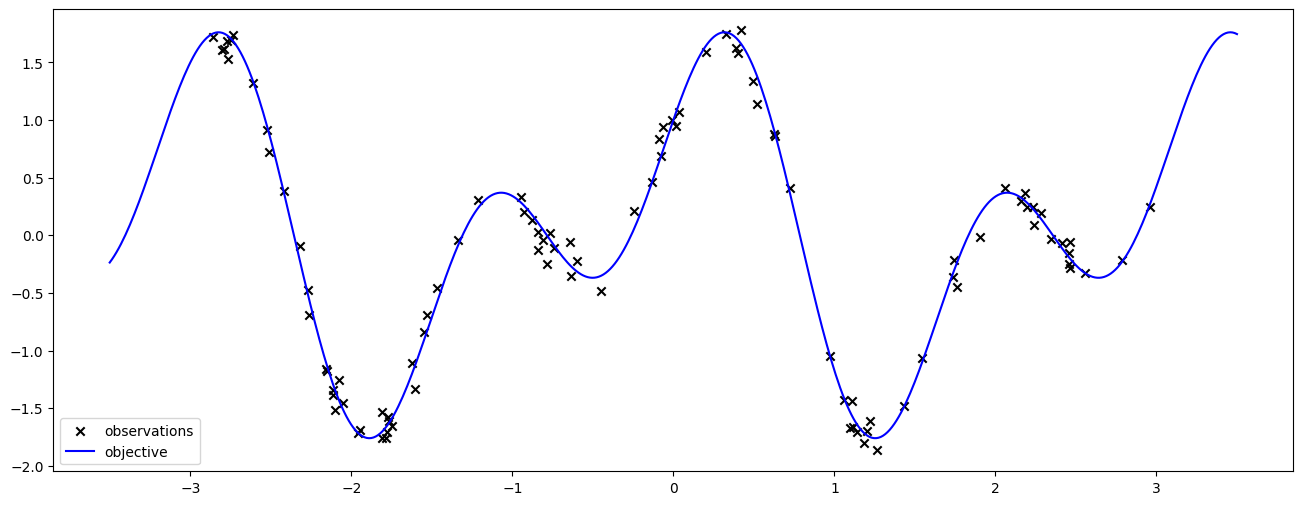

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.scatter(x_train, y_train, color='black', marker='x', label='observations')
ax.plot(x_test, y_test, color='blue', label='objective')
ax.legend()

plt.show()

## Fitting the gaussian process model

With the sythentic training dataset in place, we can move on to fitting a gaussian process model to the data. For that, we define a broad prior over all candidate latent functions consisting of a zero-mean gaussian process with a scaled RBF kernel. Note, we constrain the prior hyperparameters `amplitude`, `length_scale`, and `noise` by the `softplus` bijector. This is crucial during training, as they are required to be positive.

In [8]:
bijector = bijectors.softplus()

In [9]:
def prior(params):
    return gaussian.prior(
        vmap(means.zero()),
        vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.rbf(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
        bijector.forward(params['noise']),
    )

Next we initialise the parameters and plot our prior destribution over the test points.

In [10]:
params = {
    'amplitude': jnp.zeros(()),
    'length_scale': jnp.zeros(()),
    'noise': jnp.array(-5.),
}

In [11]:
prior_mean, prior_cov = prior(params)(x_test)
prior_scale = jnp.sqrt(jnp.diag(prior_cov))

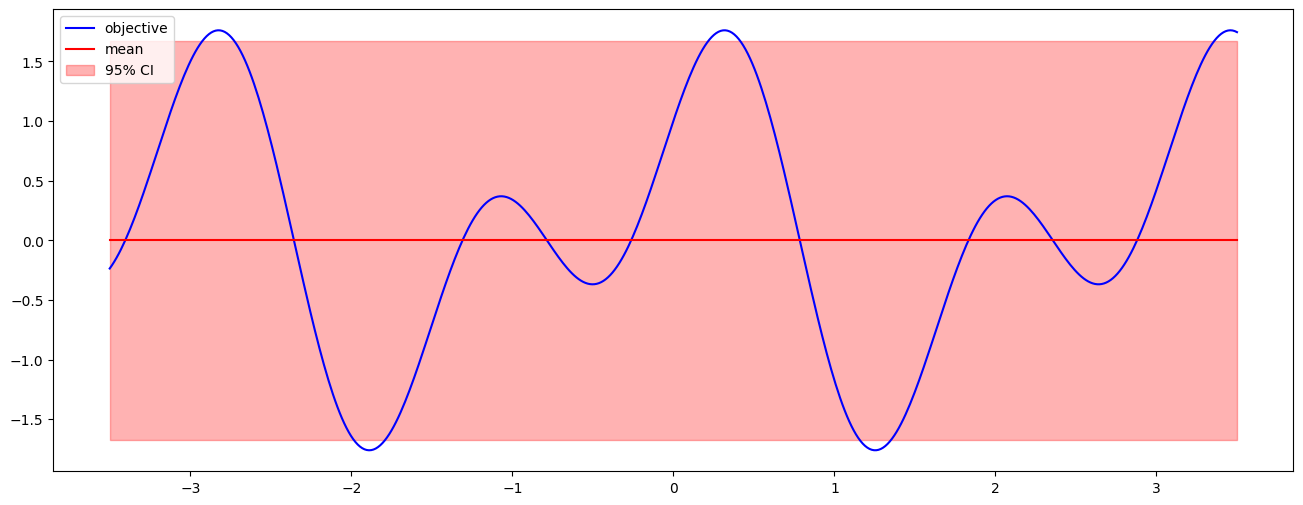

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(x_test, y_test, color='blue', label='objective')
ax.plot(x_test, prior_mean, color='red', label='mean')
ax.fill_between(x_test.flatten(), prior_mean - 2 * prior_scale, prior_mean + 2 * prior_scale, color='red', alpha=0.3, label='95% CI')
ax.legend()

plt.show()

To fit the parameters we use the Adam optimizer by minimizing the negative log likelihood on the training dataset.

In [13]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(params)

In [14]:
def train_step(state, iteration):
    def loss_fn(params):            
        loc, scale = prior(params)(x_train)
        return -scipy.stats.multivariate_normal.logpdf(y_train, loc, scale)

    loss, grads = value_and_grad(loss_fn)(state[0])
    updates, opt_state = optimizer.update(grads, state[1])
    params = optax.apply_updates(state[0], updates)
    
    return (params, opt_state), loss

In [15]:
(next_params, next_opt_state), history = lax.scan(jit(train_step), (params, opt_state), jnp.arange(500))

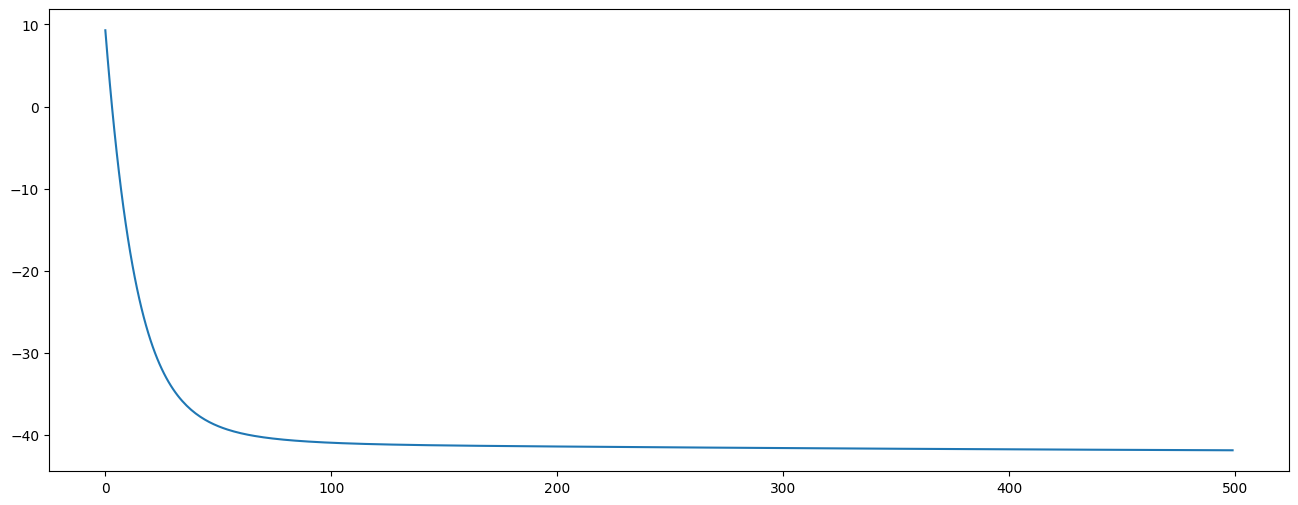

In [16]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(history, label='Negative Log Likelihood')

plt.show()

## Prediction

As the final step construct the posterior distribution by conditioning the prior on the training data and plot its mean and confidence interval as well as some samples against the noisy training data and ground truth latent function.

In [17]:
posterior_mean, posterior_cov = gaussian.posterior(
    x_train,
    y_train,
    vmap(means.zero()),
    vmap(vmap(kernels.scale(bijector.forward(next_params['amplitude']), kernels.rbf(bijector.forward(next_params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
    bijector.forward(next_params['noise']),
)(x_test)

In [18]:
posterior_scale = jnp.sqrt(jnp.diag(posterior_cov))
posterior_samples = random.multivariate_normal(sample_key, posterior_mean, posterior_cov, shape=(20,)).T

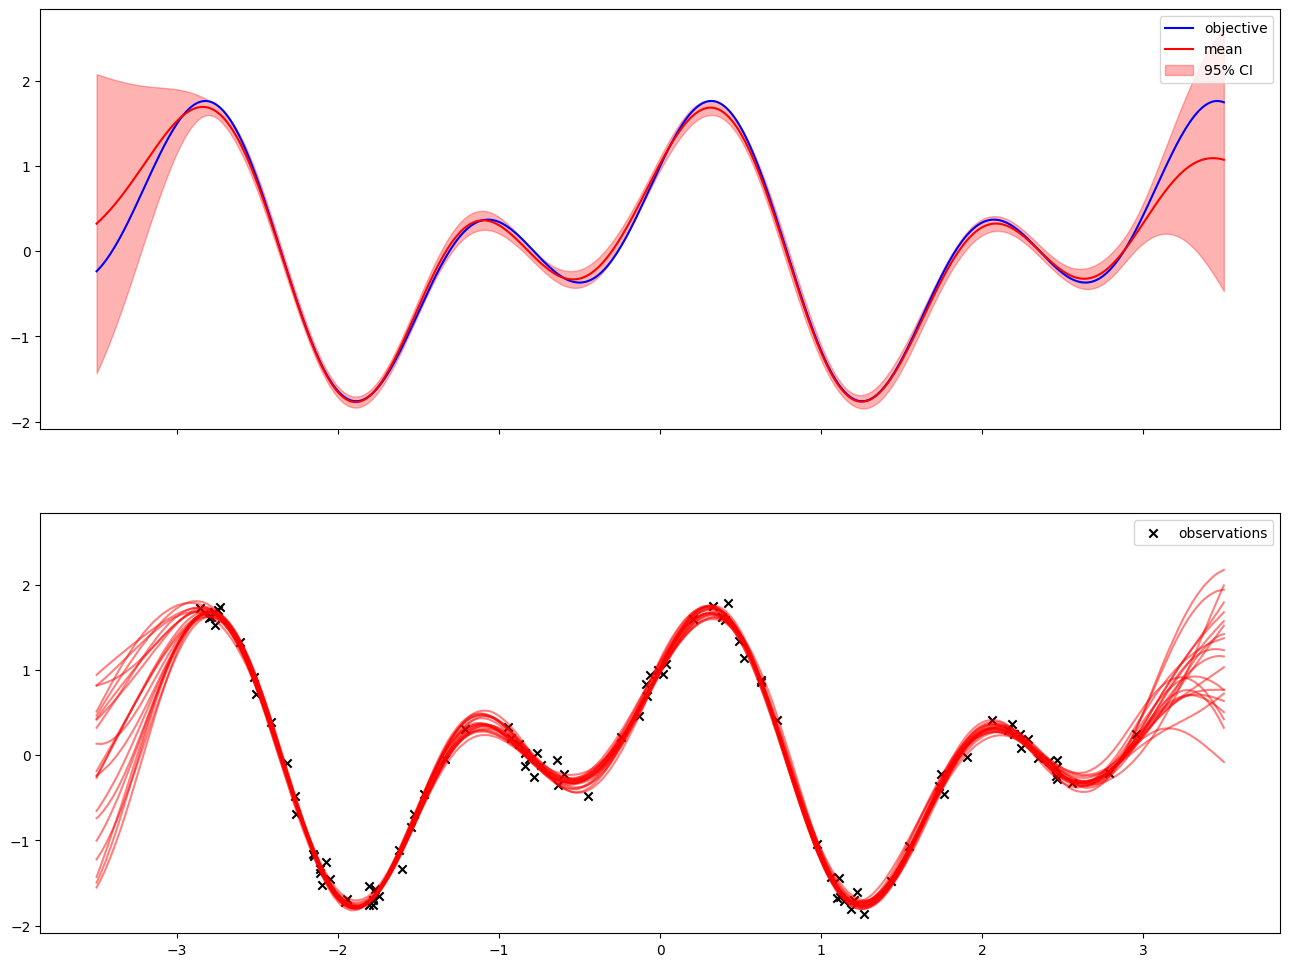

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12), sharex=True, sharey=True)

axs[0].plot(x_test, y_test, color='blue', label='objective')
axs[0].plot(x_test, posterior_mean, color='red', label='mean')
axs[0].fill_between(x_test.flatten(), posterior_mean - 2 * posterior_scale, posterior_mean + 2 * posterior_scale, color='red', alpha=0.3, label='95% CI')
axs[0].legend()

axs[1].scatter(x_train, y_train, color='black', marker='x', label='observations')
axs[1].plot(x_test, posterior_samples, color='red', alpha=0.5)
axs[1].legend()

plt.show()